#Requirements

In [1]:
!pip3 install moabb

#Define Networks

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

class EEG_TCNet(nn.Module):
    def __init__(self, F1, F2, F_T, K_E, K_T, n_chan, n_cls, dropout_E, dropout_T, L=2):
        super(EEG_TCNet, self).__init__()
        self.blk_1 = nn.Sequential(
            nn.Conv2d(
                1,
                F1,
                kernel_size=(1, K_E),
                padding=(0, K_E//2)
            ),
            nn.BatchNorm2d(F1)
        )

        self.blk_2 = nn.Sequential(
            nn.Conv2d(
                F1,
                F1 * 2,
                kernel_size=(n_chan, 1),
                groups=F1
            ),
            nn.BatchNorm2d(F1 * 2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(p=dropout_E)
        )

        self.blk_3 = nn.Sequential(
            # Depthwise conv
            nn.Conv2d(
                F1 * 2,
                F1 * 2,
                kernel_size=(1, 16),
                groups=F1 * 2,
                padding=(0, 8)
            ),
            # Pointwise conv
            nn.Conv2d(
                F1 * 2,
                F2,
                kernel_size=(1, 1)
            ),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(p=dropout_E)
        )

        self.tcn_blocks = nn.ModuleList()
        for i in range(L):
            dilation = 2 ** i
            in_channels = F2 if i == 0 else F_T
            self.tcn_blocks.append(
                TCN_ResidualBlock(
                    in_channels=in_channels,
                    out_channels=F_T,
                    kernel_size=K_T,
                    dilation=dilation,
                    dropout=dropout_T
                )
            )
        self.blk_5 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(F_T, n_cls)
        )

    def forward(self, x):
        x = self.blk_1(x)
        x = self.blk_2(x)
        x = self.blk_3(x)
        for tcn_block in self.tcn_blocks:
            x = tcn_block(x)

        x = self.blk_5(x)
        return x


class TCN_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super(TCN_ResidualBlock, self).__init__()
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.left_pad = dilation * (kernel_size - 1)

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=(1, kernel_size),
                dilation=(1, dilation)
            ),
            nn.BatchNorm2d(out_channels),
            nn.ELU(),
            nn.Dropout(p=dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=(1, kernel_size),
                dilation=(1, dilation)
            ),
            nn.BatchNorm2d(out_channels),
            nn.ELU(),
            nn.Dropout(p=dropout)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1)),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.pad(x, (self.left_pad, 0, 0, 0), mode='constant', value=0)
        x = self.conv1(x)
        x = F.pad(x, (self.left_pad, 0, 0, 0), mode='constant', value=0)
        x = self.conv2(x)
        return x + residual

#Train & Test
####using BCI competition IV 2a

Subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Using device: cuda
Data shape - Train: (4608, 22, 876), Val: (576, 22, 876)
Number of classes: 4
Epoch 10/100 - Loss: 1.1075, Val Acc: 0.5017, Val Kappa: 0.3356
Epoch 20/100 - Loss: 1.0355, Val Acc: 0.5399, Val Kappa: 0.3866
Epoch 30/100 - Loss: 0.9930, Val Acc: 0.5608, Val Kappa: 0.4144
Epoch 40/100 - Loss: 0.9733, Val Acc: 0.5677, Val Kappa: 0.4236
Epoch 50/100 - Loss: 0.9558, Val Acc: 0.5625, Val Kappa: 0.4167
Epoch 60/100 - Loss: 0.9366, Val Acc: 0.5729, Val Kappa: 0.4306
Epoch 70/100 - Loss: 0.9372, Val Acc: 0.5990, Val Kappa: 0.4653
Epoch 80/100 - Loss: 0.9322, Val Acc: 0.5642, Val Kappa: 0.4190
Epoch 90/100 - Loss: 0.9241, Val Acc: 0.5712, Val Kappa: 0.4282
Epoch 100/100 - Loss: 0.8970, Val Acc: 0.5920, Val Kappa: 0.4560
Best Results (Subject 1): Accuracy: 0.6215, Kappa: 0.4954
Data shape - Train: (4608, 22, 876), Val: (576, 22, 876)
Number of classes: 4
Epoch 10/100 - Loss: 1.0409, Val Acc: 0.2847, Val Kappa: 0.0463
Epoch 20/100 - Loss: 0.9

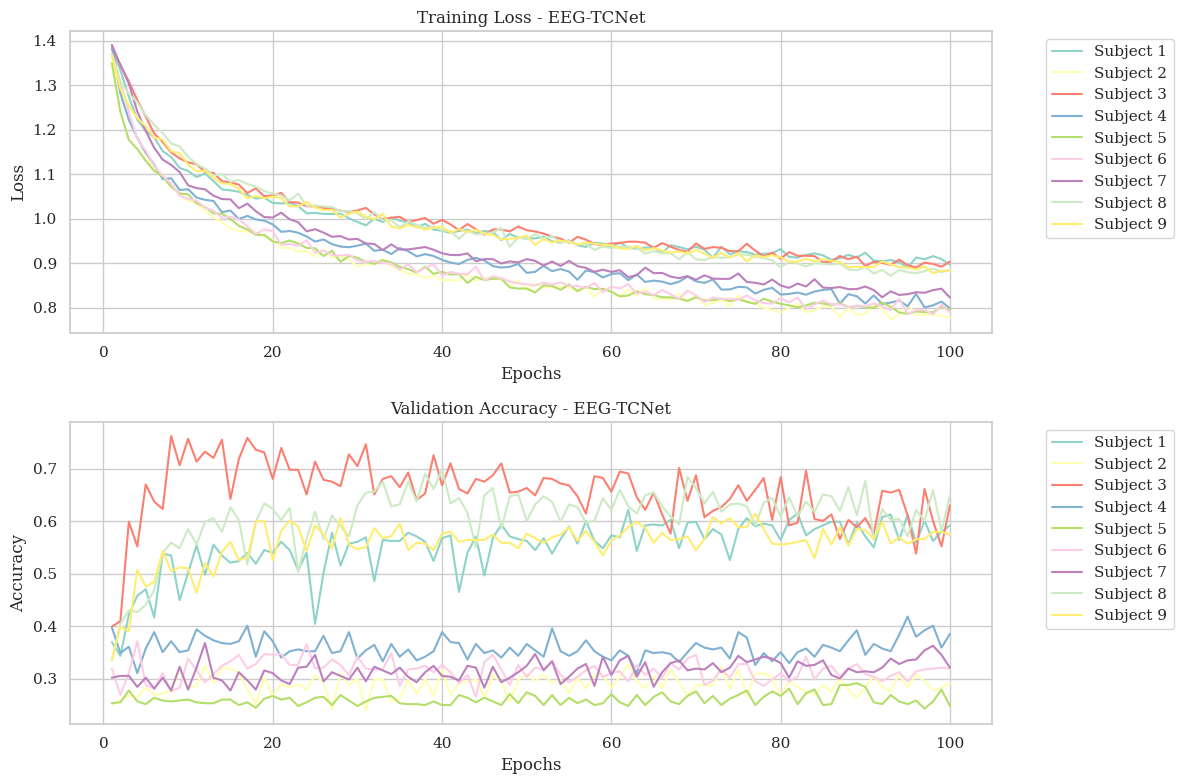

In [9]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
from moabb import datasets
from moabb.paradigms import MotorImagery
from collections import Counter
import numpy as np

def create_eeg_tcnet_fixed(n_chan=22, n_cls=4):
    return EEG_TCNet(
        F1=8, F2=16, F_T=12, K_E=32, K_T=4,
        n_chan=n_chan, n_cls=n_cls,
        dropout_E=0.2, dropout_T=0.3, L=2
    )


# train & test
def train_eeg_tcnet():
    # using BCI Competition IV 2a dataset
    dataset = datasets.BNCI2014_001()
    paradigm = MotorImagery(n_classes=4, tmin=0.5, tmax=4.0)# MI

    subjects = dataset.subject_list
    print(f"Subjects: {subjects}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    all_results = []
    all_kappa_scores = []
    all_loss_histories = []
    all_val_acc_histories = []

    # LOO-CV
    for test_subj in subjects:
        train_subs = [s for s in subjects if s != test_subj]

        X_train, y_train, _ = paradigm.get_data(dataset=dataset, subjects=train_subs)
        X_val, y_val, _ = paradigm.get_data(dataset=dataset, subjects=[test_subj])
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_val = le.transform(y_val)

        # processing imbalanced data
        class_counts = Counter(y_train)
        total_samples = len(y_train)
        weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))]).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)

        # normalization
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
        X_val = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)

        C, T = X_train.shape[1], X_train.shape[2]
        n_classes = len(np.unique(y_train))

        print(f"Data shape - Train: {X_train.shape}, Val: {X_val.shape}")
        print(f"Number of classes: {n_classes}")

        # to tensors
        X_train = X_train[:, np.newaxis, :, :]
        X_val = X_val[:, np.newaxis, :, :]
        X_train = torch.FloatTensor(X_train)
        y_train = torch.LongTensor(y_train)
        X_val = torch.FloatTensor(X_val)
        y_val = torch.LongTensor(y_val)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
        model = create_eeg_tcnet_fixed(n_chan=C, n_cls=n_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        num_epochs = 100
        best_val_acc = 0
        best_val_kappa = 0

        loss_history = []
        val_acc_history = []

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            loss_history.append(avg_train_loss)

            model.eval()
            val_preds, val_true = [], []
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    outputs = model(batch_x)
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_true.extend(batch_y.cpu().numpy())

            val_acc = accuracy_score(val_true, val_preds)
            val_kappa = cohen_kappa_score(val_true, val_preds)
            val_acc_history.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_val_kappa = val_kappa

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f}, "
                      f"Val Acc: {val_acc:.4f}, Val Kappa: {val_kappa:.4f}")

        all_results.append(best_val_acc)
        all_kappa_scores.append(best_val_kappa)
        all_loss_histories.append(loss_history)
        all_val_acc_histories.append(val_acc_history)

        print(f"Best Results (Subject {test_subj}): "
              f"Accuracy: {best_val_acc:.4f}, Kappa: {best_val_kappa:.4f}")
    if all_results:
        mean_acc = np.mean(all_results)
        std_acc = np.std(all_results)
        mean_kappa = np.mean(all_kappa_scores)

        print("\n" + "="*50)
        print("FINAL RESULTS:")
        print("="*50)
        for i, (acc, kappa) in enumerate(zip(all_results, all_kappa_scores), start=1):
            print(f"Subject {i}: Accuracy = {acc:.4f}, Kappa = {kappa:.4f}")

        print(f"\nOverall: Accuracy = {mean_acc:.4f} ± {std_acc:.4f}, "
              f"Kappa = {mean_kappa:.4f}")
        plot_training_curves(all_loss_histories, all_val_acc_histories, subjects, num_epochs)

        return all_results, all_kappa_scores
    else:
        print("No results to report.")
        return [], []


def plot_training_curves(all_loss_histories, all_val_acc_histories, subjects, num_epochs):
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.unicode_minus'] = False

    colors = plt.cm.Set3(np.linspace(0, 1, len(subjects)))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    epochs_range = range(1, num_epochs + 1)

    for i, (loss_h, val_h) in enumerate(zip(all_loss_histories, all_val_acc_histories)):
        ax1.plot(epochs_range, loss_h, color=colors[i], label=f'Subject {subjects[i]}')
        ax2.plot(epochs_range, val_h, color=colors[i], label=f'Subject {subjects[i]}')

    import matplotlib.ticker as ticker
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(20))

    ax1.set_title('Training Loss - EEG-TCNet')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)

    ax2.set_title('Validation Accuracy - EEG-TCNet')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('eeg_tcnet_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    results, kappa_scores = train_eeg_tcnet()